# OneMax Problem
The problem is very simple, we search for a 1 filled solution. This notebook will cover creating a program to evolve a solution to this problem as well as go a little more in detail on the step of the algorithm.

## Imports
We first get the required modules for our evolution.

- `random` gives us a way to generate random bits;
- `base` gives us access to the Toolbox and base Fitness;
- `creator` allows us to create our types;
- `tools` grants us access to the operators bank;
- `algorithms` enables us some ready generic evolutionary loops.

In [2]:
import random
from deap import base, creator, tools, algorithms

## Type Creation
First step with DEAP is to create the required types. Usually the types created are the fitness and the individual. For the OneMax problem, we want to have a solution with as many ones as possible. Thus we need a maximizing fitness and a individual that is a sorted container, we'll choose the standard `list`.

Type creation is done by calling the function `create` in the creator module. This function takes two mandatory arguments and additional optional arguments. The first argument is the actual name of the type that we want to create. The second argument is the base classe that the new type created should inherit from. Finally, the optional arguments are members to add to the new type.

In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

The first line creates a maximizing fitness by replacing, in the base type Fitness, the pure virtual weights attribute by (1.0,) that means to maximize a single objective fitness. The second line creates an Individual class that inherits the properties of list and has a fitness attribute of the type FitnessMax that was just created.

Single objective is considered by DEAP the same way a multi objective function would but with a single value. The weights (as well as the returned value from the evaluation) are **always required** to be iterable.

The created classes are made available in the creator module. We can instantiate directly objects of the created class like follow. This step is not required in an algorithm, the instatiation will be automated later.

In [4]:
ind = creator.Individual([1, 0, 1, 1, 0])

print(ind)
print(type(ind))
print(type(ind.fitness))

[1, 0, 1, 1, 0]
<class 'deap.creator.Individual'>
<class 'deap.creator.FitnessMax'>


## Toolbox
The toolbox is intended to store functions with their arguments under standard aliases for uses in algorithms. Functions are registered by a function call with two mandatory arguments, the alias to give to the function and the function it will be associate with. Any additional argument will be given as argument when the alias is called.

In [5]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In the last block of code we created a toolbox object and registered three functions. This first one, `attr_bool`, calls randint from the random module with arguments (0, 1) to create an integer in the interval $[0, 1]$. The second function, `individual`, when called, will use the initRepeat function made available in the tools module to fill an `Individual` class with what is produced by 100 calls to the previously defined `attr_bool` function. The same thing is done for the `population` function.

For example, calling every function individually shows how it proceeds.

In [6]:
bit = toolbox.attr_bool()
ind = toolbox.individual()
pop = toolbox.population(n=3)

print("bit is of type %s and has value\n%s" % (type(bit), bit))
print("ind is of type %s and contains %d bits\n%s" % (type(ind), len(ind), ind))
print("pop is of type %s and contains %d individuals\n%s" % (type(pop), len(pop), pop))

bit is of type <class 'int'> and has value
1
ind is of type <class 'deap.creator.Individual'> and contains 10 bits
[0, 1, 1, 1, 1, 1, 0, 0, 0, 1]
pop is of type <class 'list'> and contains 3 individuals
[[1, 1, 1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 0, 1, 1, 1, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0, 1]]


## Evaluation Function
The evaluation function is pretty simple for the OneMax problem, we need to count the number of ones in an individual. We recall here that the returned value must be an iterable of length equal to the number of objectives (weights).

In [7]:
def evalOneMax(individual):
    return sum(individual),

## Genetic Operators
Registering the operators and their default arguments in the toolbox is done as follow.

In [8]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)

The evaluation is given the alias `evaluate`. Having a single argument being the individual to evaluate we don’t need to fix any, the individual will be given later in the algorithm. The two points crossover function is registered the same way under the alias `mate`. The mutation, for its part, needs an argument to be fixed (the independent probability of each attribute to be mutated `indpb`). In the algorithms the `mutate()` function is called with the signature `toolbox.mutate(mutant)`. This is the most convenient way because each mutation takes a different number of arguments, having those arguments fixed in the toolbox leave open most of the possibilities to change the mutation (crossover, selection, or evaluation) operator later in your researches. Finally, the selection operator is registered under the name `select` and the size of the tournament set to 3.

We can for example mutate an individual and expect 10% of its attributes to be flipped.

In [9]:
ind = toolbox.individual()
print(ind)
toolbox.mutate(ind)
print(ind)

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 1]


The operators execute their behaviour on the individuals in place, meaning that if the individual is not copied before modified the old individual is lost. Copying an individual is done with the `clone` function available in every toolbox.

In [10]:
mutant = toolbox.clone(ind)
print(mutant is ind)
print(mutant == ind)

False
True


## Evolving the Population
The main program shall be defined in a main function. All previous declarations are put in the global scope of the module to make created objects available for further use in other user experiments.

The main program is very simple. It consists of generating a population, and giving it to the algorithm for it to evolve a solution. Here we will employ some helpful introspection tools such as Statistics and a Hall of Fame. The statistics are computed using `numpy` functions on the population, and the hall of fame keeps track of the best individuals that ever appeared during the evolution. The algorithm take as arguments, among other, the population and the toolbox. Once the evolution is finished the population contains the individuals from the last generation.

In [11]:
def main():
    import numpy
    
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

Next, we protect our call to the main function and launch the evolution, the verbose argument tell to output the stats on every generations. We can print and plot the data returned. 

gen	nevals	avg 	min	max
0  	50    	5.52	2  	10 
1  	23    	7.3 	5  	10 
2  	30    	8.38	7  	10 
3  	29    	9.12	6  	10 
4  	35    	9.62	8  	10 
5  	36    	9.82	8  	10 
6  	25    	9.88	8  	10 
7  	24    	9.88	8  	10 
8  	26    	9.76	6  	10 
9  	35    	9.64	8  	10 
10 	27    	9.7 	6  	10 
Best individual is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
with fitness: (10.0,)


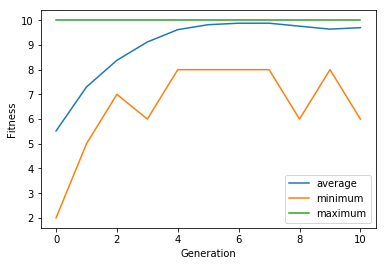

In [13]:
if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    import matplotlib.pyplot as plt
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.show()